In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['r/s', 'w/s', 'kr/s', 'kw/s', 'wait', 'actv', 'wsvc_t', 'asvc_t', '%w', '%b', 'device']
TEST_CONFIG = 'fixed-rate-submit'
DISK_CONFIG = 'ssd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['c1t1d0', 'c1t2d0', 'c1t3d0', 'c2t0d0', 'c2t1d0', 'c2t2d0',
         'c4t0d0', 'c4t1d0', 'c4t2d0', 'c3t0d0', 'c3t1d0']

seaborn.set(font_scale=1.5)

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(30, 15), style=':o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(30, 15), style=':o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(30, 15), style=':o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'results/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%b', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'results/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%b', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# OpenZFS #447 Performance Results - Fixed Rate Submit on SSDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would attempt to acheive a bandwidth of about 64 writes per second; i.e. after a write completes, the thread may artficially delay, such that it doesn't exceed its target of 64 write operations per second. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

# Real world random request flow follows Poisson process. To give better
# insight on latency distribution, we simulate request flow under Poisson
# process.
rate_process=poisson
rate_iops=64

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 32 vCPUs
 - 512 GB of RAM
 - Solid State Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below is a graph of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

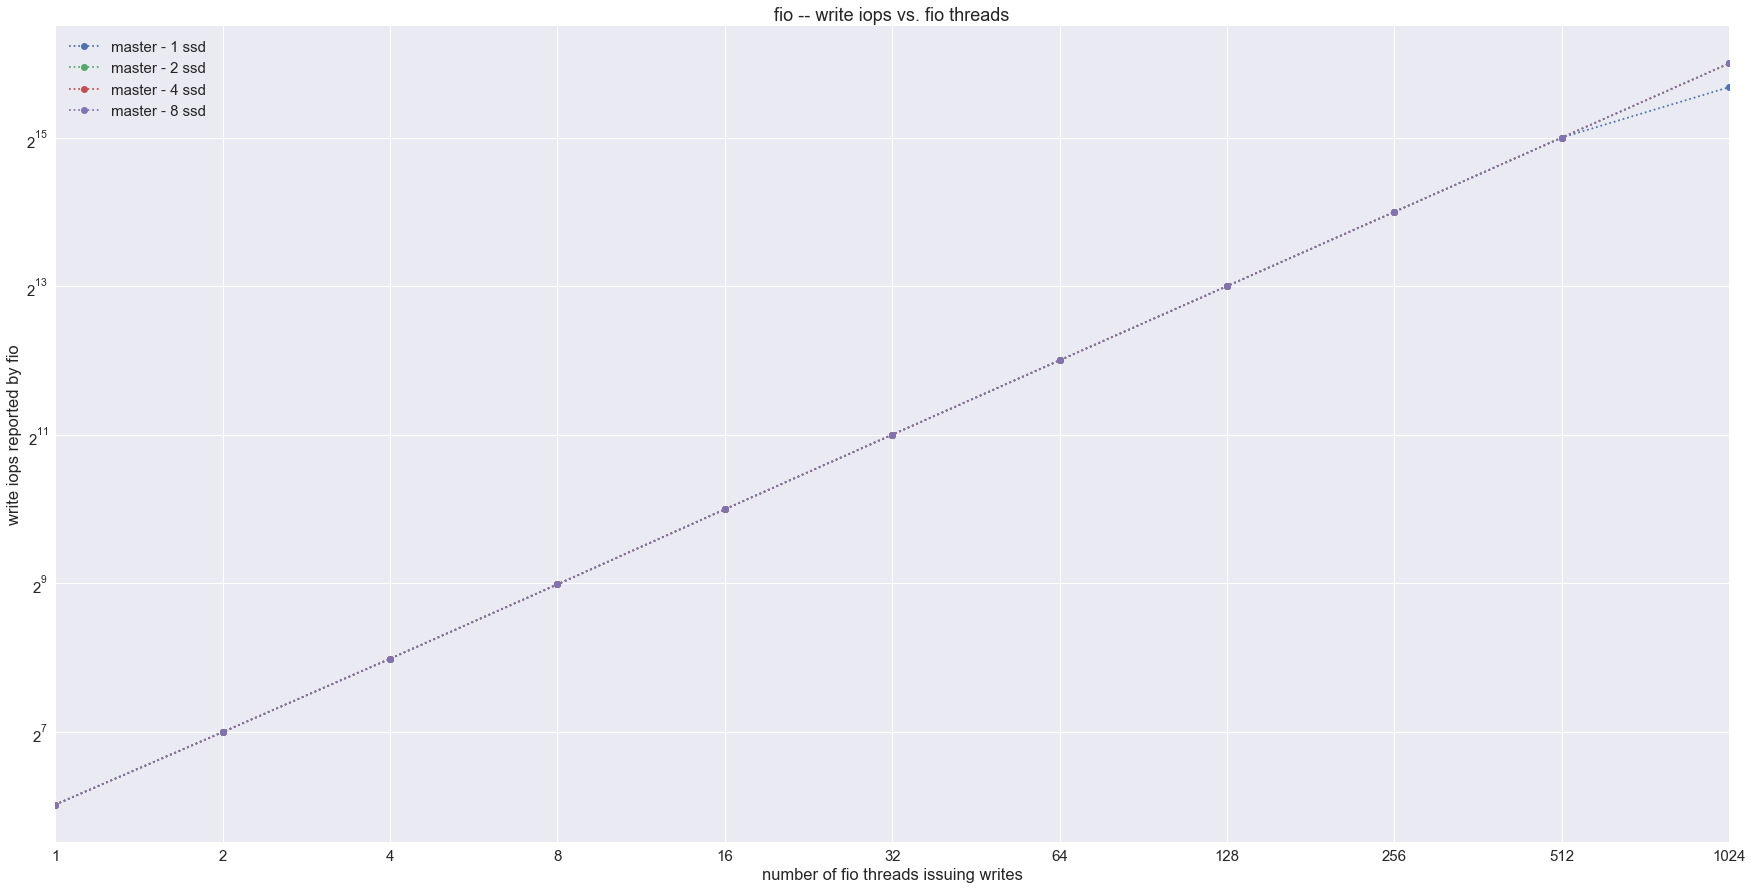

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,65.01,65.01,65.01,65.01
2,127.86,127.87,127.86,127.87
4,253.52,253.52,253.52,253.52
8,507.24,507.28,507.25,507.28
16,1021.53,1021.70,1021.53,1021.70
32,2049.10,2049.08,2049.08,2049.10
64,4100.60,4100.60,4100.60,4100.37
128,8191.46,8191.44,8191.46,8191.46
256,16375.18,16374.20,16375.10,16375.22
512,32745.93,32746.34,32742.47,32745.64


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

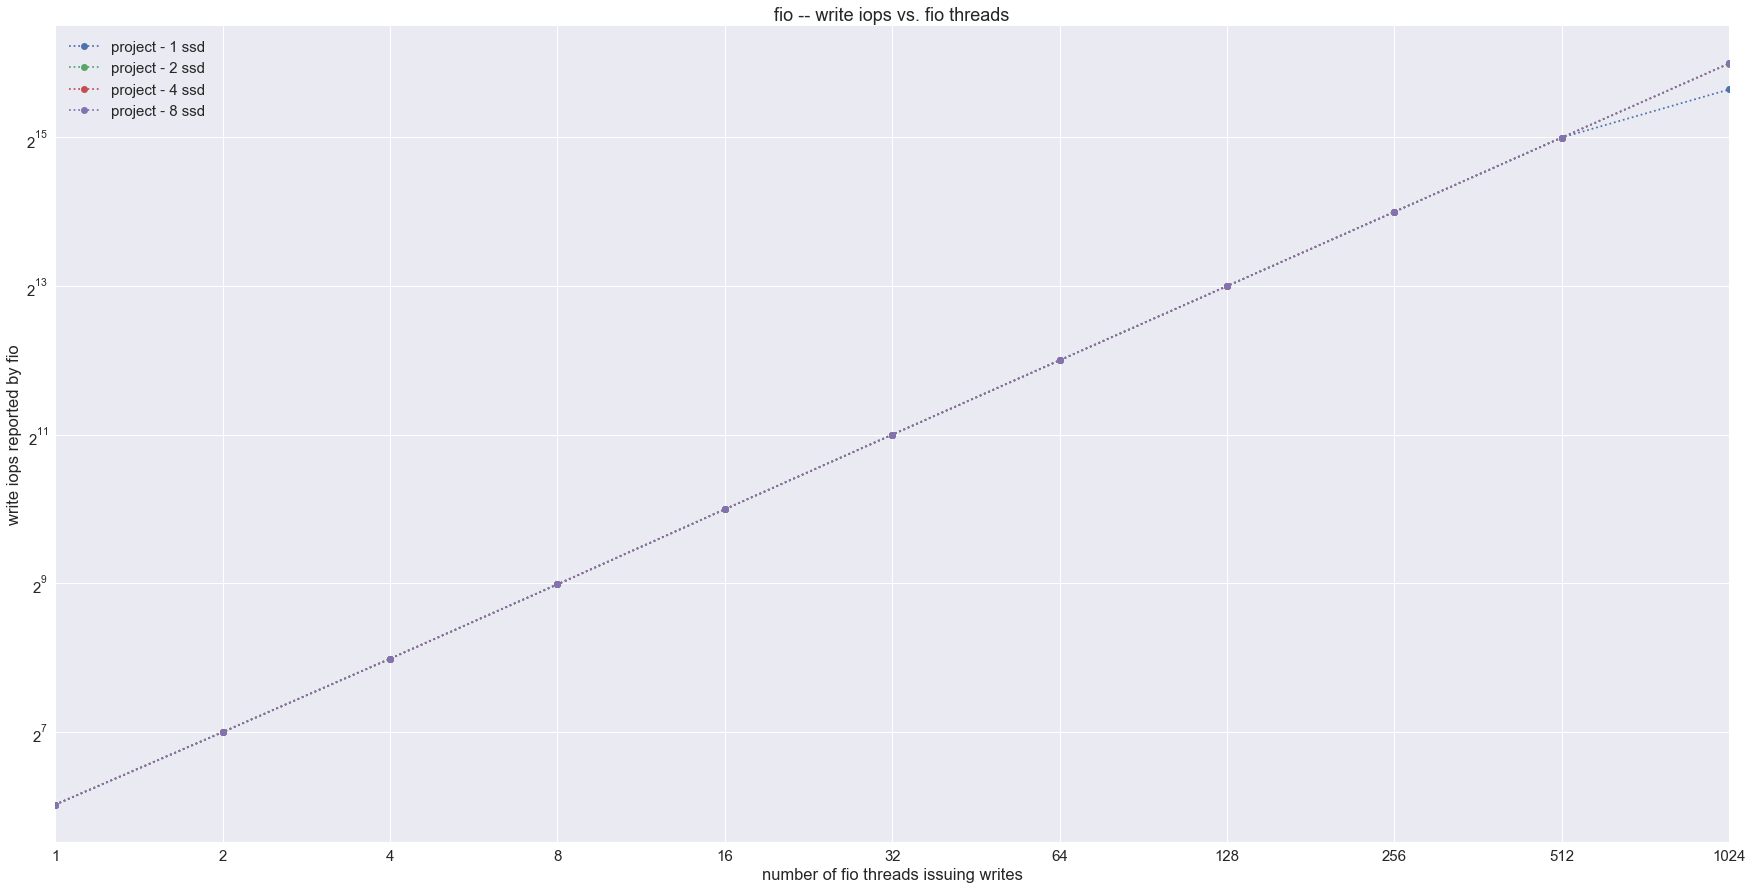

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,65.01,65.01,65.01,65.01
2,127.87,127.86,127.87,127.87
4,253.52,253.52,253.52,253.52
8,507.28,507.28,507.28,507.28
16,1021.70,1021.63,1021.70,1021.70
32,2049.10,2049.10,2049.08,2049.10
64,4100.62,4100.60,4100.60,4100.60
128,8191.46,8191.48,8191.46,8191.48
256,16375.27,16374.70,16375.28,16374.27
512,32747.09,32746.61,32746.57,32747.22


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

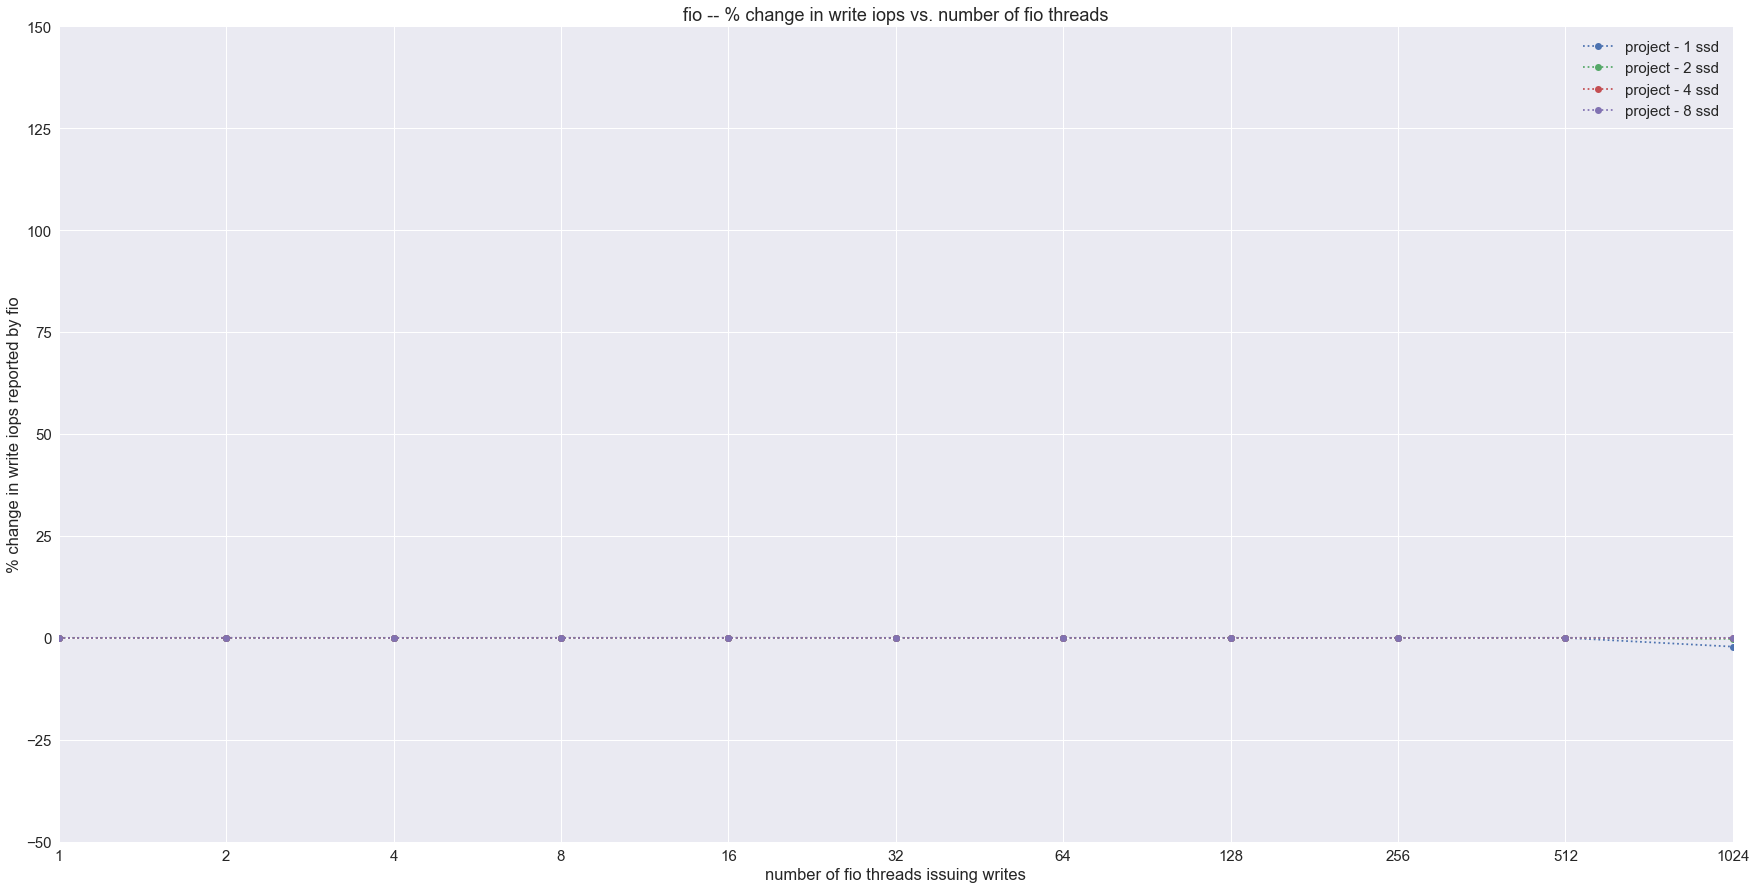

In [7]:
pctchange_iops.plot(figsize=(30, 15), style=':o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-50, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.show()

In [8]:
pctchange_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,0.000000,0.000000,0.000000,0.000000
2,0.007821,-0.007820,0.007821,0.000000
4,0.000000,0.000000,0.000000,0.000000
8,0.007886,0.000000,0.005914,0.000000
16,0.016642,-0.006851,0.016642,0.000000
32,0.000000,0.000976,0.000000,0.000000
64,0.000488,0.000000,0.000000,0.005609
128,0.000000,0.000488,0.000000,0.000244
256,0.000550,0.003054,0.001099,-0.005801
512,0.003542,0.000825,0.012522,0.004825


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

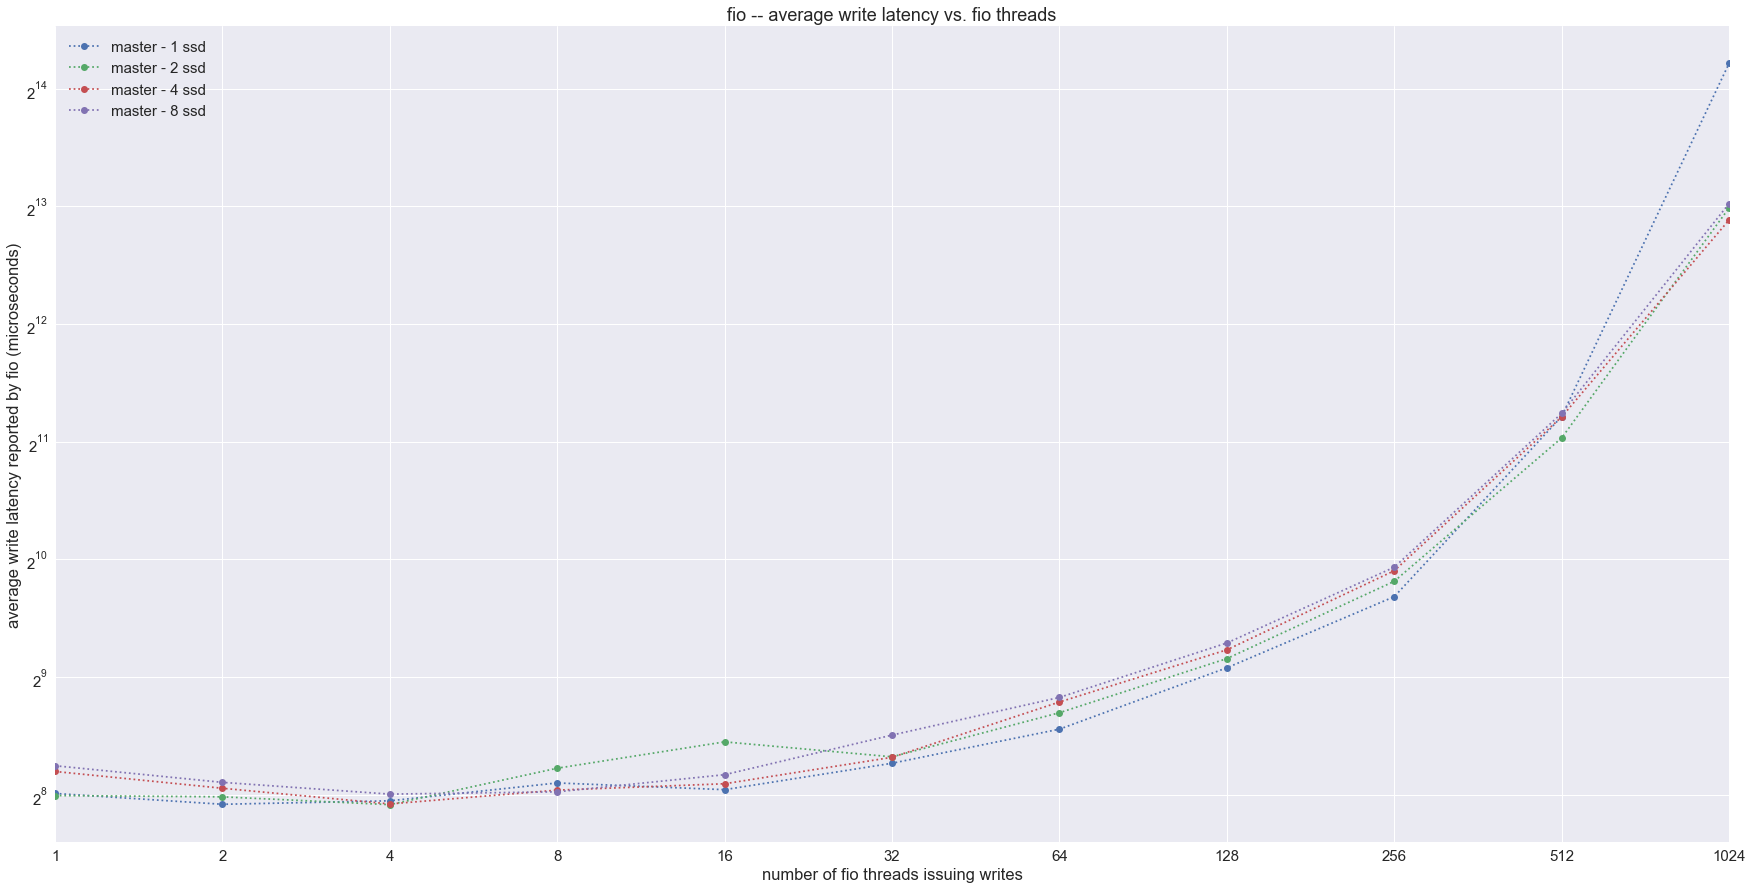

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,257.58,254.43,293.21,303.27
2,241.66,252.51,265.58,274.95
4,246.68,241.13,242.15,256.56
8,274.03,298.88,262.69,260.08
16,263.38,349.07,272.74,287.69
32,307.75,319.63,318.71,363.31
64,376.20,414.50,441.47,453.56
128,540.04,570.09,600.39,625.05
256,821.17,899.02,956.72,976.80
512,2373.29,2091.83,2368.13,2418.09


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

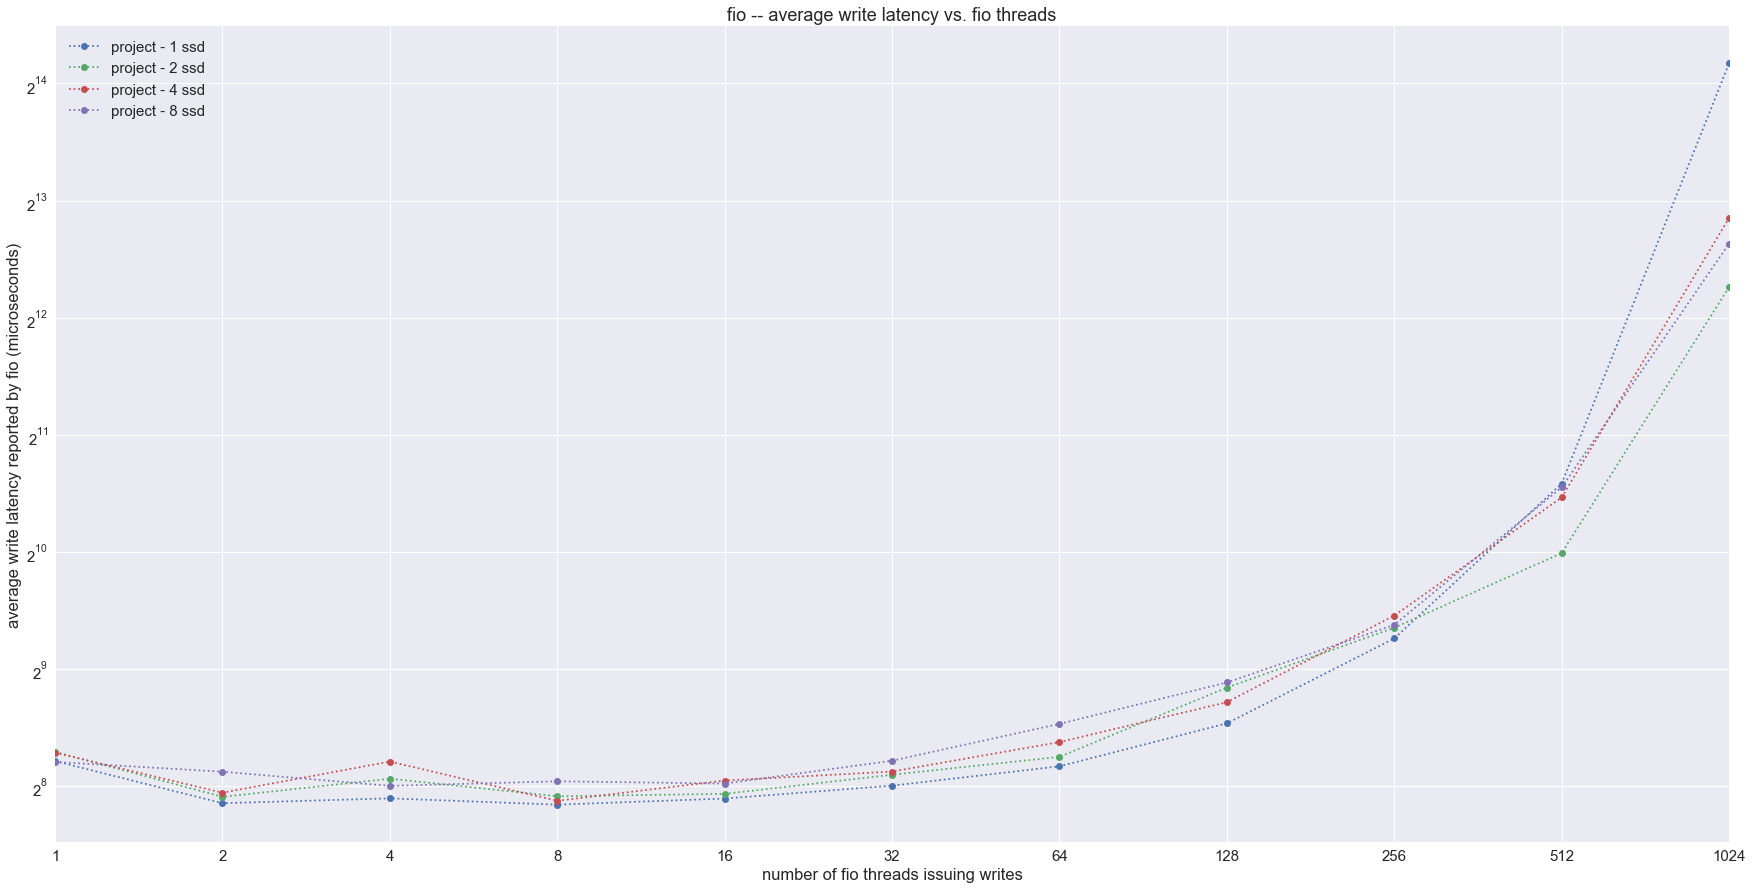

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,297.22,313.84,312.39,295.73
2,231.64,240.55,246.50,279.11
4,238.39,267.77,296.34,256.68
8,229.66,241.40,234.98,263.74
16,238.10,244.81,264.91,260.19
32,256.98,274.18,279.38,297.84
64,288.16,304.73,332.57,370.44
128,371.59,459.10,421.14,473.20
256,614.07,654.27,703.03,665.63
512,1535.48,1017.09,1414.45,1501.32


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

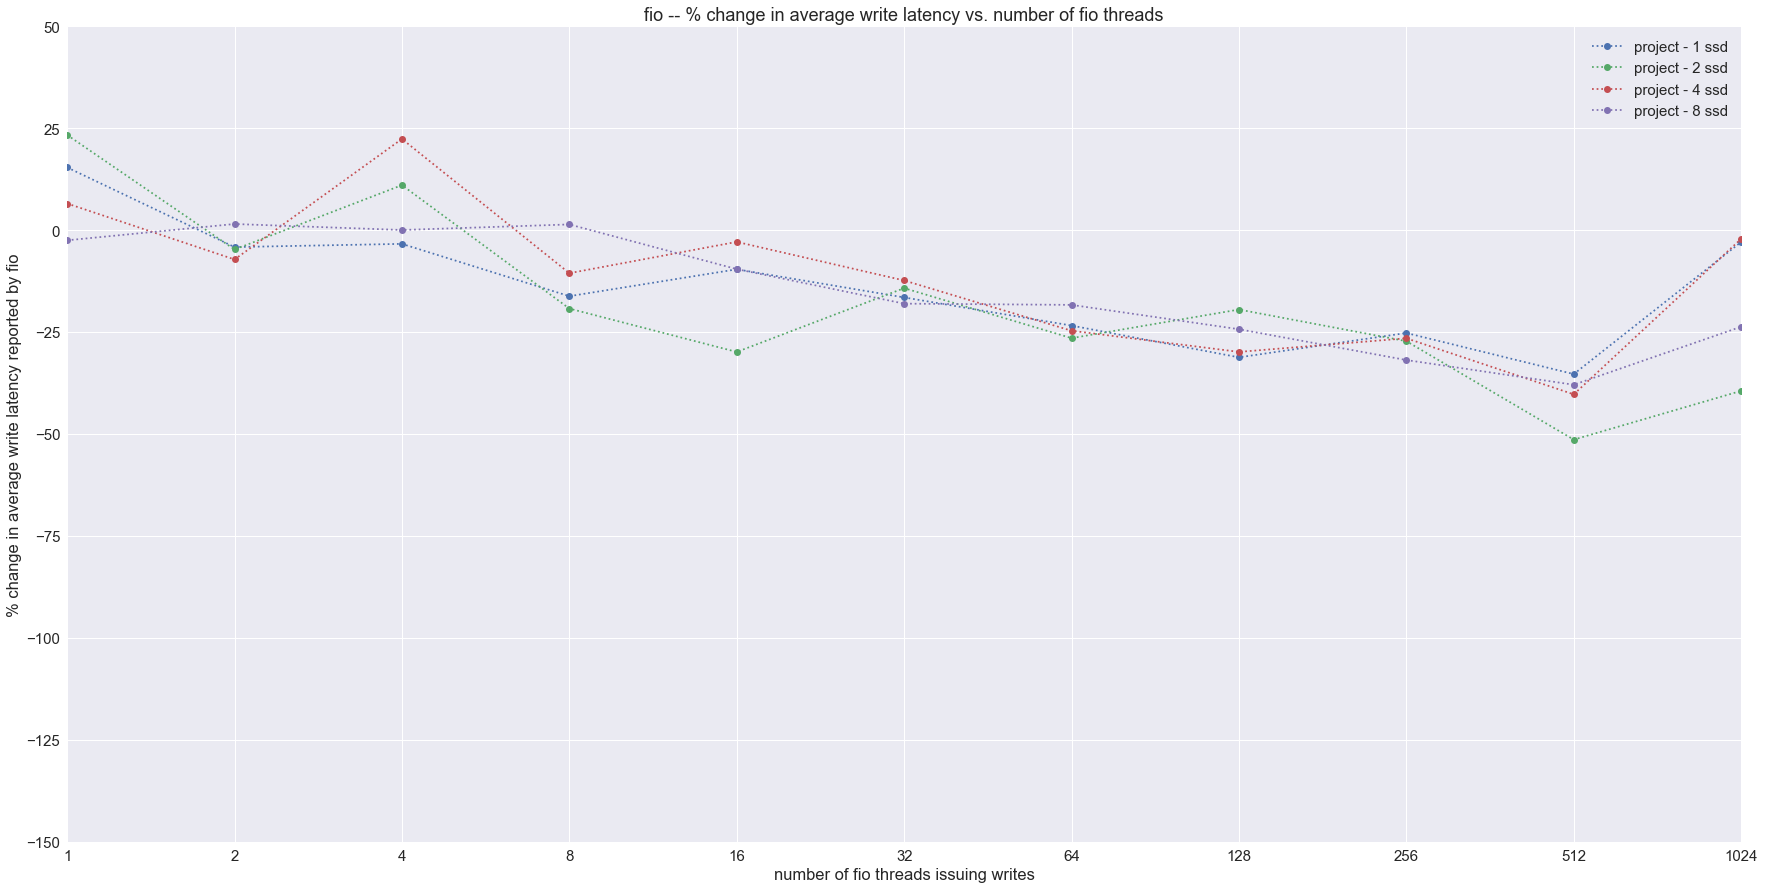

In [13]:
pctchange_latency.plot(figsize=(30, 15), style=':o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-150, 50)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.show()

In [14]:
pctchange_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,15.389394,23.350234,6.541387,-2.486233
2,-4.146321,-4.736446,-7.184276,1.513002
4,-3.360629,11.047982,22.378691,0.046773
8,-16.191658,-19.231799,-10.548555,1.407259
16,-9.598299,-29.867935,-2.870866,-9.558900
32,-16.497157,-14.219566,-12.340372,-18.020423
64,-23.402446,-26.482509,-24.667588,-18.326131
128,-31.192134,-19.468856,-29.855594,-24.294056
256,-25.220113,-27.224088,-26.516640,-31.856061
512,-35.301628,-51.377980,-40.271438,-37.912981


## `%b` averaged across all disks in zpool vs. `fio` threads

Below is a graph of the `%b` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -xn 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%b` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%b` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%b` averaged across all disks in zpool vs. `fio` threads - master branch

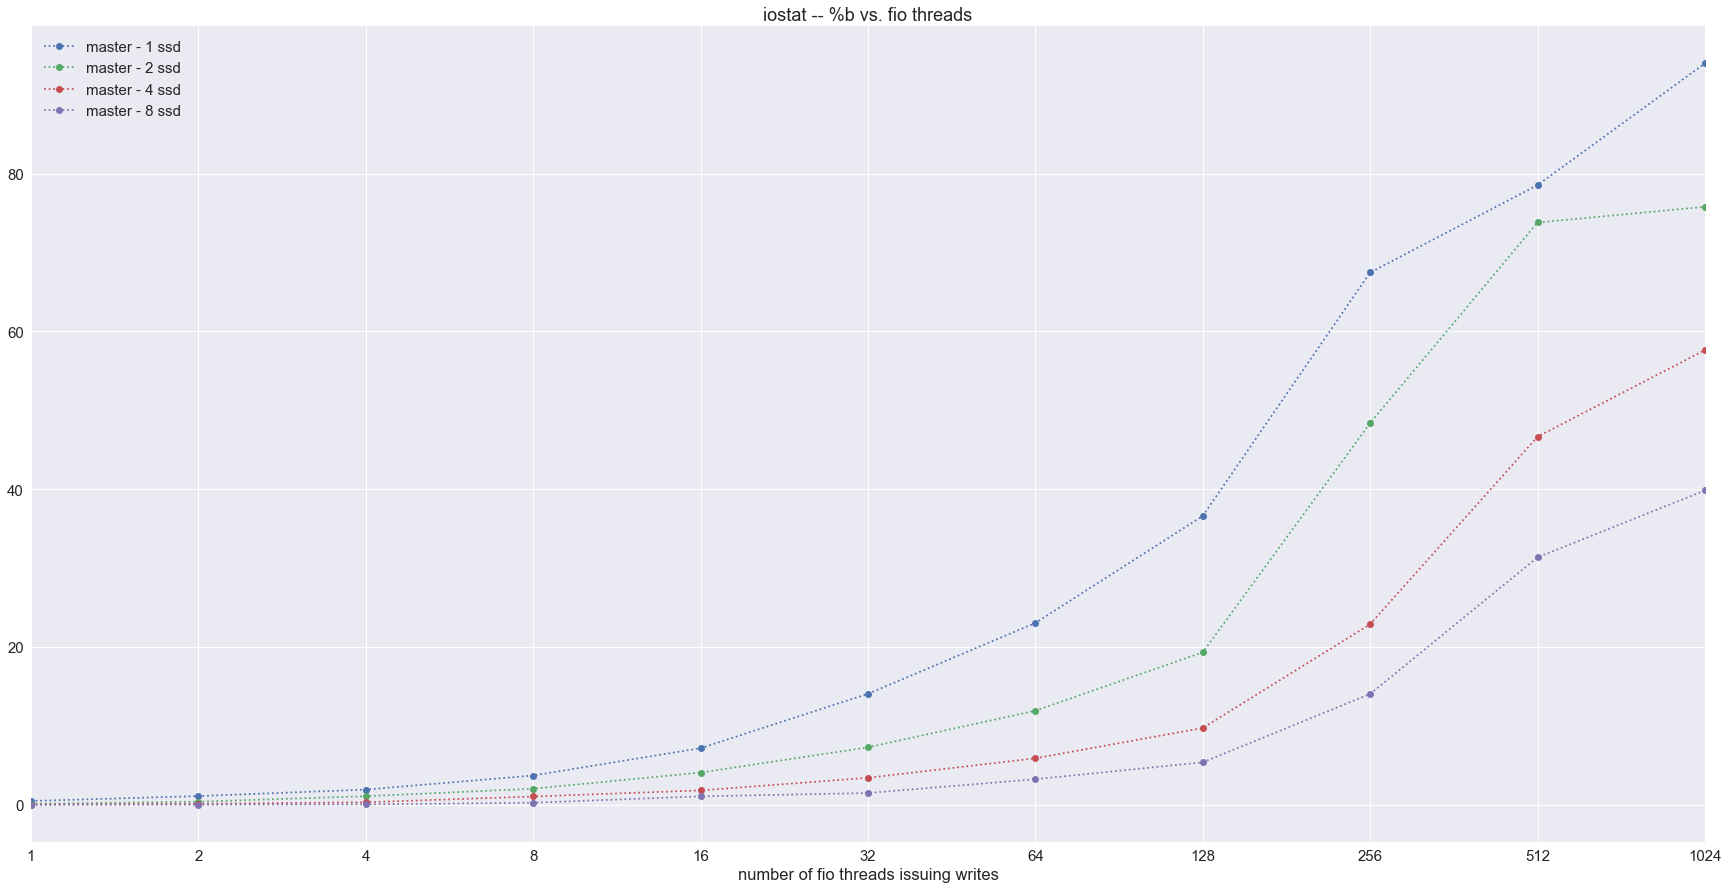

In [15]:
plot_iostat_column_dataframe(master_busy, '%b')

In [16]:
master_busy

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,0.464286,0.107143,0.000000,0.000000
2,1.089286,0.375000,0.107143,0.000000
4,1.910714,1.071429,0.303571,0.035088
8,3.696429,2.017857,1.035088,0.245614
16,7.160714,4.071429,1.807018,1.052632
32,14.053571,7.267857,3.403509,1.473684
64,23.035714,11.910714,5.877193,3.228070
128,36.607143,19.315789,9.719298,5.368421
256,67.473684,48.385965,22.877193,14.034483
512,78.551724,73.810345,46.655172,31.355932


### `%b` averaged across all disks in zpool vs. `fio` threads - project branch

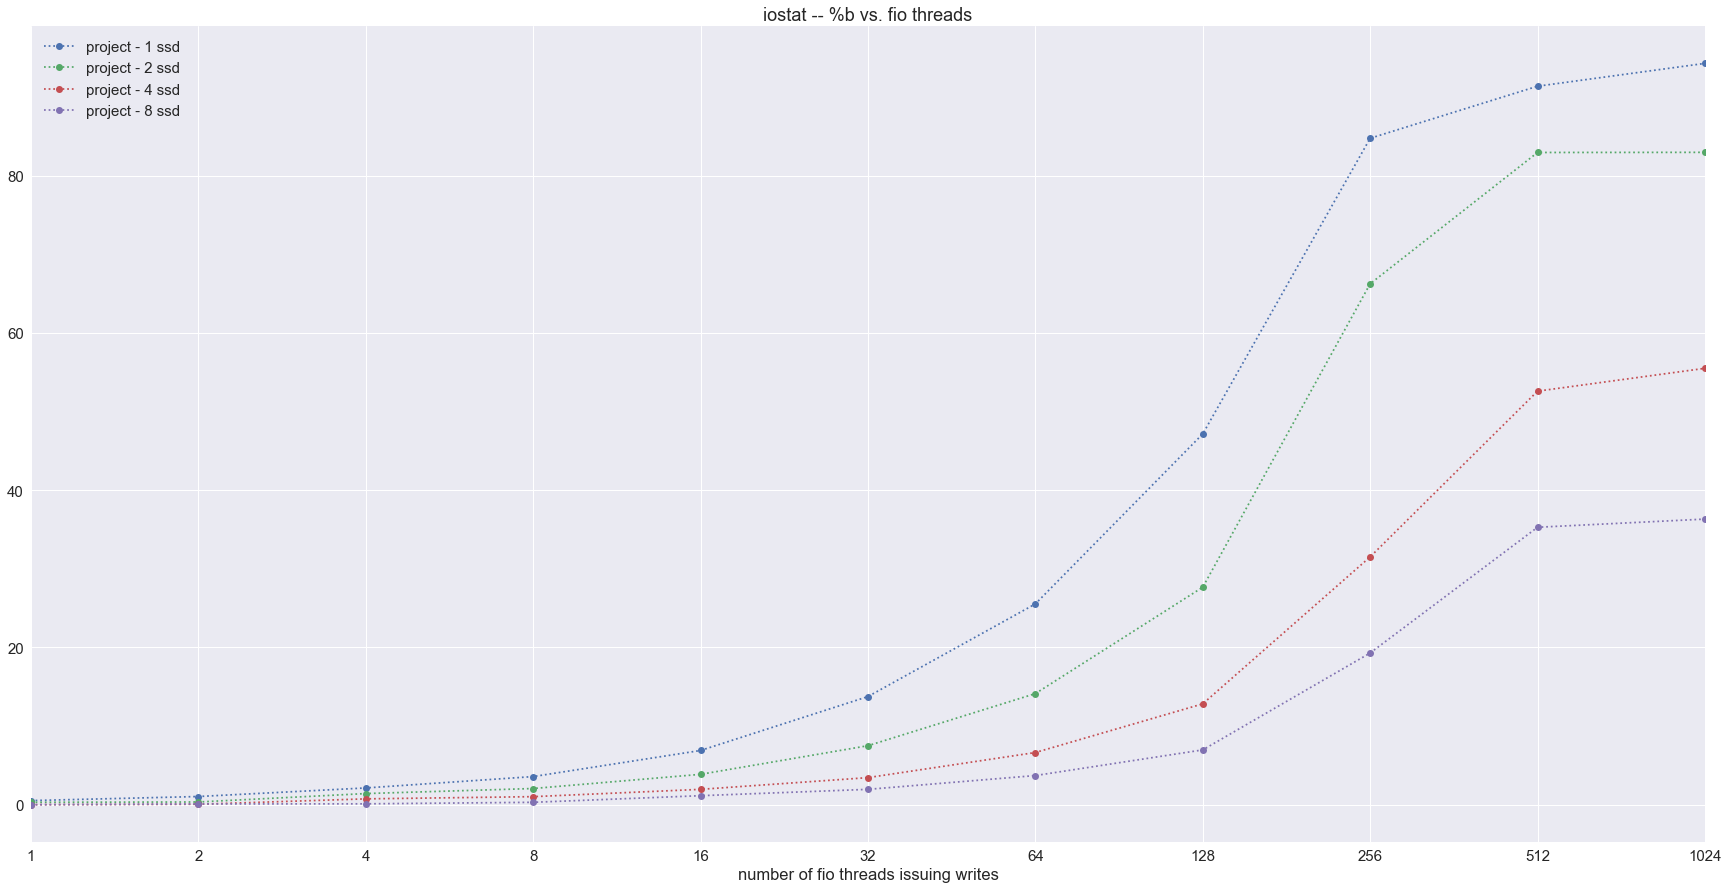

In [17]:
plot_iostat_column_dataframe(project_busy, '%b')

In [18]:
project_busy

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,0.517857,0.303571,0.000000,0.000000
2,1.035714,0.339286,0.053571,0.087719
4,2.125000,1.410714,0.736842,0.105263
8,3.571429,2.053571,1.017544,0.298246
16,6.892857,3.857143,1.947368,1.140351
32,13.750000,7.500000,3.438596,1.947368
64,25.535714,14.125000,6.631579,3.701754
128,47.160714,27.660714,12.824561,6.965517
256,84.771930,66.263158,31.517241,19.293103
512,91.396552,82.965517,52.603448,35.288136


## on-cpu, system wide, kernel flame graphs

The visualizations below are on-cpu flame-graphs of the entire system, using kernel level stacks. Unlike the line graphs above, there isn't a straightforward way to condense all of the test runs into a single flame-graph visualization. Thus, instead of showing the unique graph for each configuration, 2 configurations were specifically chosen with hopes that these two show a representative sample of the whole population. The two chosen configurations are:

 - 1 disk zpool, with 1024 `fio` threads
 - 8 disk zpool, with 1024 `fio` threads

Both configurations have the largest number of `fio` threads available; and then one configuration has the largest number of disks, and the other configuration has the least number of disks.

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - master branch

![image](fixed-rate-submit-master-1-ssd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - project branch

![image](fixed-rate-submit-project-1-ssd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - master branch

![image](fixed-rate-submit-master-8-ssd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - project branch

![image](fixed-rate-submit-project-8-ssd-fio-1024-jobs-dtrace-profile.svg)